In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from numpy import cos,sin,sqrt
%matplotlib inline

# Tight-binding Hamiltonian

In [2]:
import pybinding as pb
from pybinding.repository import group6_tmd
py_model = pb.Model(group6_tmd.monolayer_3band("MoS2"), pb.translational_symmetry())

In [3]:
a1,a2=py_model.lattice.vectors
k1,k2=py_model.lattice.reciprocal_vectors()

In [4]:
def hamiltonian(k):
    a1,a2=py_model.lattice.vectors
    k1,k2=py_model.lattice.reciprocal_vectors()
    a1=3.190/10
    e1=0.683;e2=1.707;
    t0=-0.146;t1=-0.114;t2=0.506;t11=0.085;t12=0.162;t22=0.073
    r0=0.060 ;r1=-0.236;r2=0.067;r11=0.016;r12=0.087;r22=0.000
    u0=-0.038;u1=0.046 ;u2=0.001;u11=0.266;u12=-0.176;u22=-0.150
    SOC=0.073
    a=k[0]*a1/2;b=k[1]*a1*sqrt(3)/2
    
    V0=e1+2*t0*(2*cos(a)*cos(b)+cos(2*a))+2*r0*(2*cos(3*a)*cos(b)+cos(2*b))+2*u0*(2*cos(2*a)*cos(2*b)+cos(4*a))
    
    V1_Re=-2*sqrt(3)*t2*sin(a)*sin(b)+2*(r1+r2)*sin(3*a)*sin(b)-2*sqrt(3)*u2*sin(2*a)*sin(2*b)
    
    V1_Im=2*t1*sin(a)*(2*cos(a)+cos(b))+2*(r1-r2)*sin(3*a)*cos(b)+2*u1*sin(2*a)*(2*cos(2*a)+cos(2*b))
    
    V2_Re=2*t2*(cos(2*a)-cos(a)*cos(b))-2/sqrt(3)*(r1+r2)*(cos(3*a)*cos(b)-cos(2*b))+2*u2*(cos(4*a)-cos(2*a)*cos(2*b))
    
    V2_Im=2*sqrt(3)*t1*cos(a)*sin(b)+2/sqrt(3)*sin(b)*(r1-r2)*(cos(3*a)+2*cos(b))+2*sqrt(3)*u1*cos(2*a)*sin(2*b)
    
    V11=e2+(t11+3*t22)*cos(a)*cos(b)+2*t11*cos(2*a)+4*r11*cos(3*a)*cos(b)+2*(r11+sqrt(3)*r12)*cos(2*b)+(u11+3*u22)*cos(2*a)*cos(2*b)+2*u11*cos(4*a)
    
    V12_Re=sqrt(3)*(t22-t11)*sin(a)*sin(b)+4*r12*sin(3*a)*sin(b)+sqrt(3)*(u22-u11)*sin(2*a)*sin(2*b)
    
    V12_Im=4*t12*sin(a)*(cos(a)-cos(b))+4*u12*sin(2*a)*(cos(2*a)-cos(2*b))
    
    V22=e2+(3*t11+t22)*cos(a)*cos(b)+2*t22*cos(2*a)+2*r11*(2*cos(3*a)*cos(b)+cos(2*b))+2/sqrt(3)*r12*(4*cos(3*a)*cos(b)-cos(2*b))+(3*u11+u22)*cos(2*a)*cos(2*b)+2*u22*cos(4*a)
    H=np.array([[V0 ,V1_Re+1j*V1_Im  ,V2_Re+1j*V2_Im],
                [V1_Re-1j*V1_Im,V11,V12_Re+1j*V12_Im],
                [V2_Re-1j*V2_Im,V12_Re-1j*V12_Im,V22]])
    Lz=np.array([[0.,0.,0.],[0.,0.,2j],[0.,-2j,0.]])
    return np.block([[H+SOC/2.*Lz,np.zeros((3,3))],[np.zeros((3,3)),H-SOC/2.*Lz]])

In [5]:
k_points = py_model.lattice.brillouin_zone()
G = np.array([0, 0])
K = k_points[0]
M = (k_points[0] + k_points[1]) / 2
kpoints=[];N1=80;N2=int(N1/2);N3=int(np.sqrt(N1**2+N2**2))
for i in range(N1):
    kpoints.append(i*K/N1+(N1-i)*G/N1)
for i in range(N2):
    kpoints.append(i*M/N2+(N2-i)*K/N2)
for i in range(N3):
    kpoints.append(i*G/N3+(N3-i)*M/N3)
kpoints=np.array(kpoints)

(-1.5, 4)

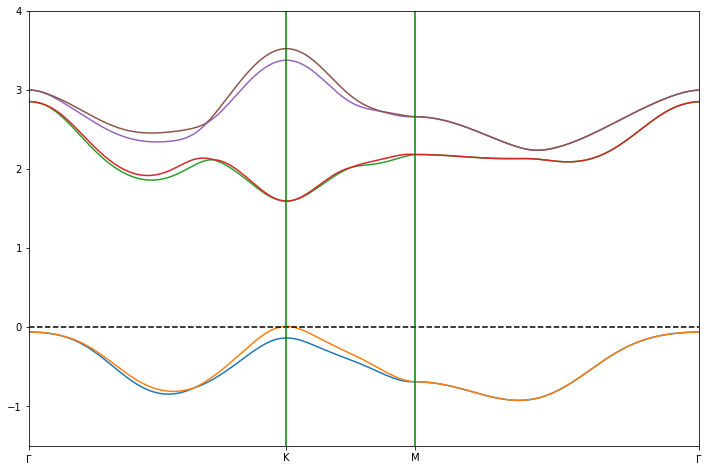

In [6]:
E=[];D=[];H=[];H_SOC=[]
norb=6;

for i in range(kpoints.shape[0]):
    H.append(hamiltonian(kpoints[i]))
for i in range(kpoints.shape[0]):
    e,d=np.linalg.eigh(H[i])
    E.append(e);D.append(d)
    
E=np.array(E);D=np.array(D)

plt.figure(figsize=(12,8))
for i in range(norb):
    plt.plot(E[:,i],'-')
plt.plot(np.linspace(0,300),np.zeros(50),'--',color='black')
plt.plot(np.ones(50)*(N1),np.linspace(-6,5),'-',color='green')
plt.plot(np.ones(50)*(N1+N2),np.linspace(-6,5),'-',color='green')
plt.xticks([0,N1,N1+N2,N1+N2+N3-1],['$\Gamma$','K','M','$\Gamma$'])
plt.xlim([0.,N1+N2+N3-1])
plt.ylim([-1.5,4])

# Interaction Hamiltonian

$H_{int}=\frac{e}{\hbar c}\vec{A}\vec{v} \\
\vec{v}=\frac{\left[\vec{r} H_{TB}\right]}{i \hbar} \\
r=i \hbar \nabla_k \\
H_{int}(k)=\frac{e}{\hbar c}\vec{A} \nabla_k H_{TB}(k) $


In [7]:
def gradient_hamiltonian(k):
    eps = np.sqrt(np.finfo(np.float).eps)
    return (hamiltonian(k+[eps,0])-hamiltonian(k))/eps

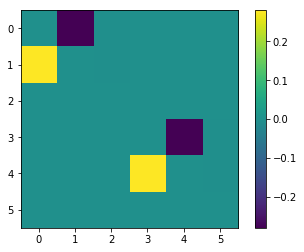

In [8]:
plt.imshow(gradient_hamiltonian(K).imag)
plt.colorbar()

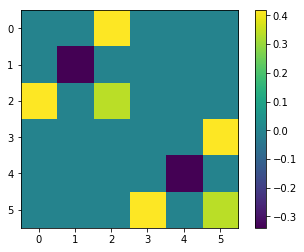

In [9]:
plt.imshow(gradient_hamiltonian(K).real)
plt.colorbar()

Пусть $F[f]$ - преобразование Фурье функции $f$, тогда

$\frac{d}{dy}F[f](y)=F[-ixf(x)](y)$

Следовательно,

$F^{-1}[\nabla_k H_{TB}(k)]=-iRH_{TB}(R)$

# Effective Hamiltonian

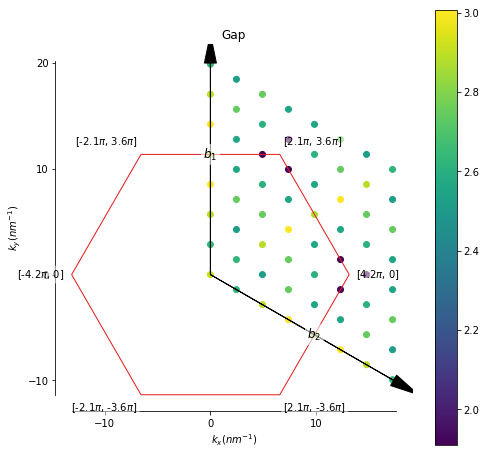

In [10]:
N=8
E=np.zeros((N,N,6));K=np.zeros((N,N,3));D=np.zeros((N,N,6,6),dtype=np.complex)
for i,j in product(range(N),range(N)):
    k=i*k1/N+j*k2/N;
    e,d=np.linalg.eigh(hamiltonian(k))
    E[i,j]=e;K[i,j]=k;D[i,j]=d
K=K.reshape((N**2,3))
E=E.reshape((N**2,6))
D=D.reshape((N**2,6,6))
plt.figure(figsize=(8,8))
py_model.lattice.plot_brillouin_zone()
plt.title('Gap')
plt.scatter(K[:,0].ravel(),K[:,1].ravel(),c=(E[:,2].ravel()-E[:,1].ravel()))
plt.colorbar()

## Constants and Keldysh potential

In [11]:
epsilon=1
h=4.135667516*10**(-15)/(2*np.pi)
c=299792458*10**9
alpha=0.65 #nm
r0=2*np.pi*alpha #nm
const=4*np.pi*h*c/137
V=N**2*np.sqrt(3)/2*(3.190/10)**2
def Keldysh_potential(q):
    q=np.linalg.norm(q)
    if q==0:
        return 0
    else:
        return const/(2*q*(1+r0*q))
#         return 0

In [16]:
v=[0,1];c=[2,3,4,5]
nv=2;nc=4
Ic=np.zeros((N**2,nc,N**2,nc),dtype=np.complex)
Iv=np.zeros((N**2,nv,N**2,nv),dtype=np.complex)

for i,ik in product(range(nv),range(N**2)):
    for j,jk in product(range(nv),range(N**2)):
        Iv[ik,i,jk,j]=np.sum(D[ik,:,v[i]].conj()*D[jk,:,v[j]])
for i,ik in product(range(nc),range(N**2)):
    for j,jk in product(range(nc),range(N**2)):
        Ic[ik,i,jk,j]=np.sum(D[ik,:,c[i]].conj()*D[jk,:,c[j]])
H=np.zeros((N**2,nc,nv,N**2,nc,nv),dtype=np.complex)
for k,i,j in product(range(N**2),range(nc),range(nv)):
    H[k,i,j,k,i,j]+=E[k,c[i]]-E[k,v[j]]
# for k1,i1,j1 in product(range(N**2),range(nc),range(nv)):
#     for k2,i2,j2 in product(range(N**2),range(nc),range(nv)):
#         H[k1,i1,j1,k2,i2,j2]-=Keldysh_potential(K[k1]-K[k2])*Ic[k2,i2,k1,i1].conj()*Iv[k2,j2,k1,j1]/V
NH=N**2*nc*nv
H=H.reshape(NH,NH)
EH,DH=np.linalg.eig(H)

In [13]:
np.min(EH)

(1.8573975070113629-1.4316215167481496e-16j)

In [17]:
np.min(EH)

(1.9097267307349988+0j)

(array([ 18.,   6.,   0.,  40.,  80., 102.,  62.,  72., 116.,  16.]),
 array([1.85739751, 2.03333224, 2.20926698, 2.38520172, 2.56113646,
        2.7370712 , 2.91300593, 3.08894067, 3.26487541, 3.44081015,
        3.61674488]),
 <a list of 10 Patch objects>)

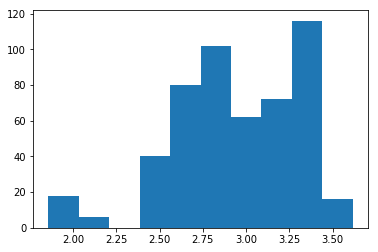

In [14]:
plt.hist(EH.real)

In [555]:
nw=500
omega=np.linspace(0,5,nw);eta=0.01
sigma=np.zeros(nw,dtype=np.complex)
def gradient_hamiltonian_X(k):
    eps = np.sqrt(np.finfo(np.float).eps)
    return (hamiltonian(k+[eps,0,0])-hamiltonian(k))/eps
I=np.zeros((N**2,nc,nv),dtype=np.complex)
for k,i,j in product(range(N**2),range(nc),range(nv)):
    grad=gradient_hamiltonian_X(K[k])
    for a,b in product(range(6),range(6)):
        I[k,i,j]+=D[k,a,j].conj()*D[k,b,i]*grad[a,b]
I=I.reshape(NH)
for w in range(nw):
    for M in range(NH):
        sigma[w]+=np.sum(np.abs(DH[M]*I)**2)/(omega[w]+1j*eta-EH[M])

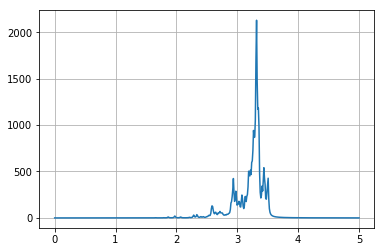

In [556]:
plt.plot(omega,-sigma.imag)
plt.grid()